In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython import display
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
random_state=42
random.seed(random_state)
np.random.seed(random_state)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-qenfwk_6 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


2.6.0


# BERT
- A language representation model presented by Google AI Language in 2019, developed by **stacking encoders of Transformer**.
- The key ideas of BERT are:
    - **Attention model** is computationally easier and even has better performance than RNN.
    - It can represent words as **subwords**.
    - Compared with other models like ELMo which are task-specific, a pre-trained BERT model **can handle a wide variety of NLP tasks such as machine translation, sentiment analysis, text summarization**.
    - While Word2Vec and Glove only generate one vector for each word, BERT can have **different embeddings for a word based on the context** (position of word) of a senetence.
    - It learns information from left and right and also from right to left.
- A complete discussion of structure in the original [paper](https://arxiv.org/pdf/1810.04805.pdf)

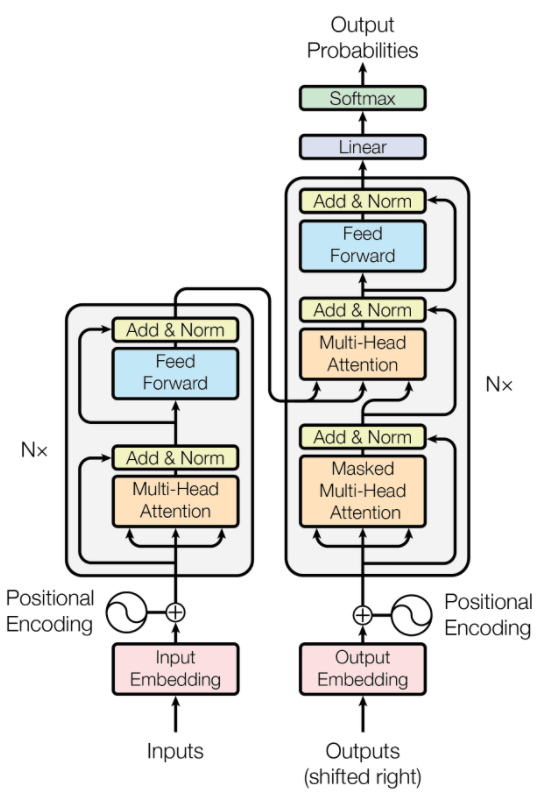

In [3]:
# Transformer architecture
# left is the encoder and right is the decoder
display.Image('img/transformer_architecture.png', width=400)

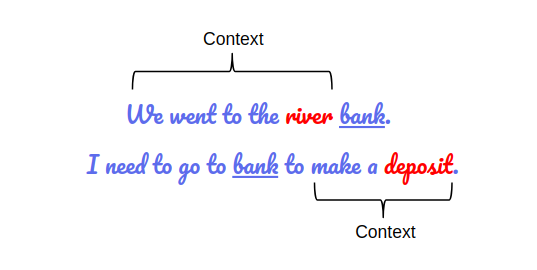

In [8]:
# importance of bidirectional
# if only learn from one side to another, the at least one meaning of the word 'bank' in the sentence below won't be captured
display.Image('img/bidirectional_learning.png')

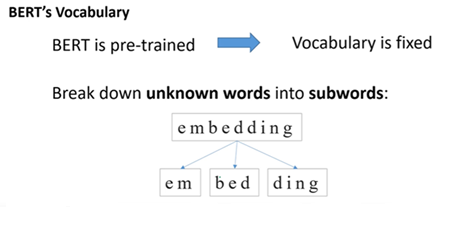

In [9]:
# bert can break down unknown word into subword for representation
# useful to guess meaning of an unknown word from known words
display.Image('img/bert_subword.png')

## Training Process
- The training involves two steps: **pretraining** a BERT model to understand the language and context, followed by **fine-tuning** to learn specific task.
- First the model is pretrained to learn what is language and what is context in **two unsupervised tasks** simultaneously, namely **Masked Language Model (MLM) and Next Sentence Prediction (NSP)**.
- For MLM, BERT randomly **masked some words in input sentences and train to output the masked content**.
- For NSP, BERT takes in two sentences and **determines if the second sentence follows the first**.
- In the fine-tunning phase, depending on the specific task, **replace the fully-connected output layer with new layer that gives the desired output**, then perform supervised learning training.

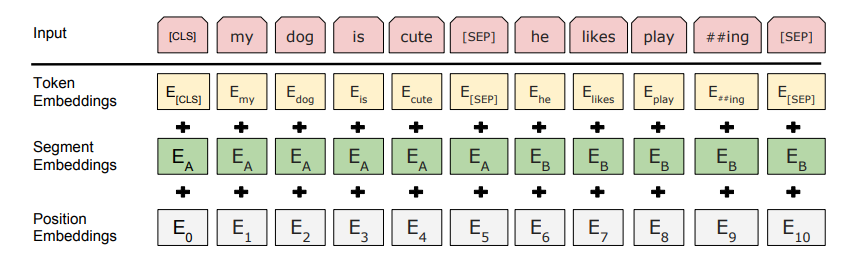

In [10]:
# BERT converts input into three embeddings
# token embedding similar to former kinds of embeddings
# segement embedding indicates relationship between sentences
# position embedding gives context meaning based on word position so to identify same words with different meanings
display.Image('img/bert_embedding.png')

# BERT on Text Classification
- We are using ATIS (Airline Travel Information System) Dataset as a demonstration of BERT on text classification problem. It is a standard benchmark dataset widely used for **intent classification**. The dataset can be found [here](https://github.com/howl-anderson/ATIS_dataset).
- The version of dataset we are using contains **enquiries that are classified into 22 differnt intents such as airfare, airline, ground service, etc**.
- Intent classification is the process of classifying the customer's goal by analyzing text, which is the first step for a chatbot to retrieve the correct information from the database.

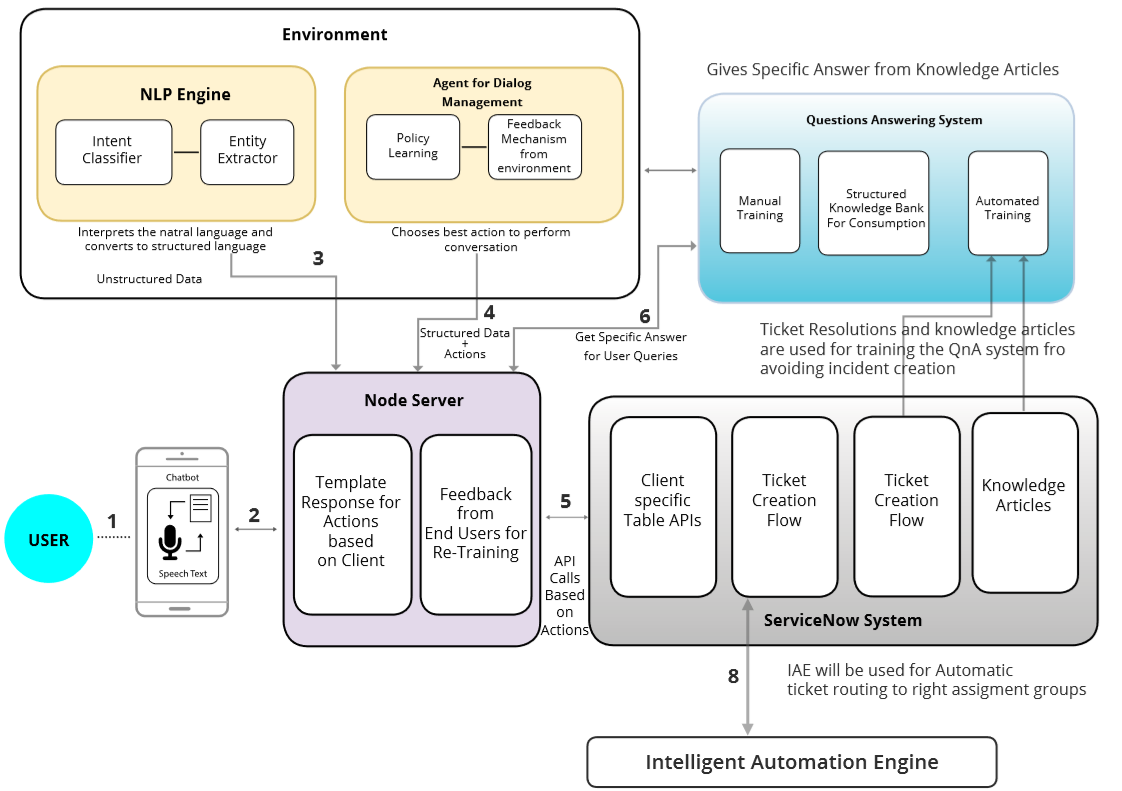

In [11]:
# architecture of chatbot
display.Image('img/chatbot architecture.png', width=1000)

## Train pretrained BERT model on specific task
- We will use the pretrained bert-base-uncased model shared on the AI community [Hugging Face](https://huggingface.co/bert-base-uncased). It is trained on English Wikipedia and 11,083 unpublished books in two objectives: Masked Language Modeling (MLM) and Next Sentence Prediction (NSP).

In [21]:
# install
# !pip install pytorch-pretrained-bert pytorch-nlp

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 123 kB 14.1 MB/s            
     |████████████████████████████████| 90 kB 68.0 MB/s            
     |████████████████████████████████| 132 kB 63.2 MB/s            
     |████████████████████████████████| 748 kB 71.2 MB/s            
     |████████████████████████████████| 79 kB 59.3 MB/s            
     |████████████████████████████████| 8.5 MB 57.9 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [14]:
# specify GPU device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    # use all GPU
# device = torch.device("cuda:1,3" if torch.cuda.is_available() else "cpu") ## specify the GPU id's, GPU id's start from 0.
n_gpu = torch.cuda.device_count()
device_names = torch.cuda.get_device_name()

print(n_gpu, device_names)

1 NVIDIA GeForce GTX 1080 Ti


In [ ]:
# load ATIS train data
import requests
url = 'https://raw.githubusercontent.com/howl-anderson/ATIS_dataset/master/data/standard_format/rasa/train.json'
r = requests.get(url)
data = json.loads(r.text)
print(data)

In [ ]:
# check data format
data['rasa_nlu_data']['common_examples']

In [17]:
# get all sentences
sentences = [d['text'] for d in data['rasa_nlu_data']['common_examples']]
# add special beginning and end token
sentences = ["[CLS] " + query + " [SEP]" for query in sentences]
sentences[0]

'[CLS] i want to fly from boston at 838 am and arrive in denver at 1110 in the morning [SEP]'

In [18]:
# get all labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = [d['intent'] for d in data['rasa_nlu_data']['common_examples']]
labels = le.fit_transform(labels)
nb_labels = len(le.classes_)
print(le.classes_)
print(nb_labels)

['abbreviation' 'aircraft' 'aircraft+flight+flight_no' 'airfare'
 'airfare+flight_time' 'airline' 'airline+flight_no' 'airport' 'capacity'
 'cheapest' 'city' 'distance' 'flight' 'flight+airfare' 'flight_no'
 'flight_time' 'ground_fare' 'ground_service' 'ground_service+ground_fare'
 'meal' 'quantity' 'restriction']
22


In [19]:
# label distribution
from collections import Counter
Counter(labels)

Counter({12: 3666,
         15: 54,
         3: 423,
         1: 81,
         17: 255,
         7: 20,
         5: 157,
         11: 20,
         0: 147,
         16: 18,
         20: 51,
         10: 19,
         14: 12,
         8: 16,
         13: 21,
         19: 6,
         21: 6,
         6: 2,
         18: 1,
         4: 1,
         9: 1,
         2: 1})

In [22]:
from pytorch_pretrained_bert import BertTokenizer, BertConfig
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, cache_dir='cache')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', '[SEP]']


In [24]:
# convert tokens to ids and pad id sequences
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 128     # max sequence length
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids[0]

array([  101,  1045,  2215,  2000,  4875,  2013,  3731,  2012,  6640,
        2620,  2572,  1998,  7180,  1999,  7573,  2012, 11118,  2692,
        1999,  1996,  2851,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [25]:
# Create attention masks to distinguish between tokens and padding
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
attention_masks[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [27]:
# Use train_test_split to split our data into train and validation sets for training
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=random_state, test_size=0.1
)
# split attention mask as the same order as splitting input_ids above
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=random_state, test_size=0.1)

In [33]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [34]:
# Create an iterator of our data with torch DataLoader for fine-tuning of BERT
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
# train data
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)    # sample data randomly
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# validation data
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [35]:
# load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
from pytorch_pretrained_bert import BertForSequenceClassification, BertAdam
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=nb_labels, cache_dir='cache')
model.cuda()    # send model to current device

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [37]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
print(param_optimizer)
# decide which parameters use weight decay (L2 regularization)
no_decay = ['bias', 'LayerNorm.weight']
# divide parameters to two groups: need to decay and need not to decay
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# do linear warmup first for the first .1 steps and then do a linearly decrease (i.e. linear decay) the learning rate from 2e-5 to 0 over the remaining number of steps
optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=.1)

t_total value of -1 results in schedule not being applied


[('bert.embeddings.word_embeddings.weight', Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       device='cuda:0', requires_grad=True)), ('bert.embeddings.position_embeddings.weight', Parameter containing:
tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-

In [43]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1)
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [44]:
# Store our loss and accuracy for plotting
from tqdm import trange
train_loss_set = []
epochs = 4
# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
    ## TRAINING
    # Set model to training mode
    model.train()  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        # CrossEntropyLoss for multiclass
        # The token type IDs are used typically in a next sentence prediction tasks
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    # avg train loss in one epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    ## VALIDATION
    # Set model to evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit (ln(p/1-p)) predictions
            # why logit is used: https://stats.stackexchange.com/questions/215349/why-use-odds-and-not-probability-in-logistic-regression
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/.local/lib/python3.6/site-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.6835351453295776


Epoch:  25%|██▌       | 1/4 [01:07<03:23, 67.98s/it]

Validation Accuracy: 0.9559461805555556
Train loss: 0.1646510406397283


Epoch:  50%|█████     | 2/4 [02:19<02:19, 69.89s/it]

Validation Accuracy: 0.9657118055555556
Train loss: 0.0872602837758937


Epoch:  75%|███████▌  | 3/4 [03:27<01:09, 69.21s/it]

Validation Accuracy: 0.9774305555555556
Train loss: 0.044140261355122286


Epoch: 100%|██████████| 4/4 [04:37<00:00, 69.48s/it]

Validation Accuracy: 0.9848090277777778


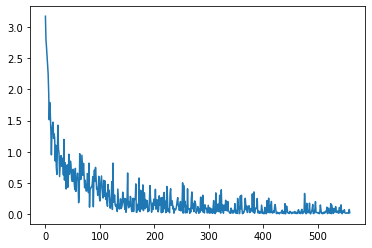

In [45]:
# plot learning curve
plt.plot(np.arange(len(train_loss_set)), train_loss_set);

## Evaluate model with test data

In [46]:
# load test data from github
url = 'https://raw.githubusercontent.com/howl-anderson/ATIS_dataset/master/data/standard_format/rasa/test.json'
r = requests.get(url)
data = json.loads(r.text)

# get all sentences
# filter data that does not belong to training labels
sentences = [d['text'] for d in data['rasa_nlu_data']['common_examples'] if d['intent'] in le.classes_]
# add special beginning and end token
sentences = ["[CLS] " + query + " [SEP]" for query in sentences]

labels = [d['intent'] for d in data['rasa_nlu_data']['common_examples'] if d['intent'] in le.classes_]
labels = le.transform(labels)
print(len(labels))

888


In [48]:
# create inputs for prediction
def preprocess_bert_input(sentences, labels):
    # tokenize test data
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    MAX_LEN = 128
    # Pad our input tokens
    input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                              maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask) 

    # create test tensors
    prediction_inputs = torch.tensor(input_ids)
    prediction_masks = torch.tensor(attention_masks)
    prediction_labels = torch.tensor(labels)
    batch_size = 32  
    prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
    return prediction_dataloader

prediction_dataloader = preprocess_bert_input(sentences, labels)

In [49]:
%%time
## Prediction on test set
def bert_prediction(model, prediction_dataloader):
    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    predictions , true_labels = [], []
    # Predict 
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()  
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1)
    flat_true_labels = [item for sublist in true_labels for item in sublist]
    return flat_true_labels, flat_predictions

flat_true_labels, flat_predictions = bert_prediction(model, prediction_dataloader)

CPU times: user 1.27 s, sys: 2.36 s, total: 3.64 s
Wall time: 3.63 s


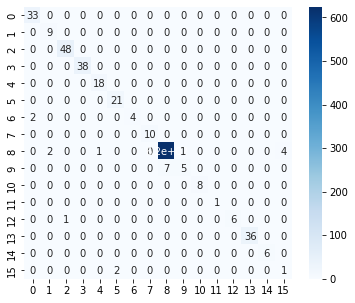

In [52]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 5)) 
cf_matrix =  confusion_matrix(flat_true_labels, flat_predictions)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=ax);

In [53]:
# weighted f1
from sklearn.metrics import f1_score
f1_score(flat_true_labels, flat_predictions, average='weighted')

0.976763289807178

In [120]:
#gpu_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.get_memory_info("GPU:0")

{'current': 0, 'peak': 0}